# QC how to!

This is oriented around using the numpy data format which is (#frames, #nodes, #coords, #individuals)

In [524]:
import glob
from natsort import natsorted
from bee_tracking import Tracking
import os
from utils.logger import logger
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy
import numpy as np


# base_dir = "/Genomics/ayroleslab2/scott/bees/data/" # Data from the old model
base_dir = "/Users/danielruttenberg/Downloads/" # Data from the new model'"
experiment_dict = {
    d: {} for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))
}

In [525]:
def flatten_features(x, axis=0):

    if axis != 0:
        # Move time axis to the first dim
        x = np.moveaxis(x, axis, 0)

    # Flatten to 2D.
    initial_shape = x.shape
    x = x.reshape(len(x), -1)

    return x, initial_shape


In [526]:
def unflatten_features(x, initial_shape, axis=0):
    # Reshape.
    x = x.reshape(initial_shape)

    if axis != 0:
        # Move time axis back
        x = np.moveaxis(x, 0, axis)

    return x

In [527]:
def fill_missing(x, kind="linear", axis=0, **kwargs):
    """Fill missing values in a timeseries.

    Args:
        x: Timeseries of shape (time, ...) or with time axis specified by axis.
        kind: Type of interpolation to use. Defaults to "nearest".
        axis: Time axis (default: 0).

    Returns:
        Timeseries of the same shape as the input with NaNs filled in.

    Notes:
        This uses pandas.DataFrame.interpolate and accepts the same kwargs.
    """
    if x.ndim > 2:
        # Reshape to (time, D)
        x, initial_shape = flatten_features(x, axis=axis)

        # Interpolate.
        x = fill_missing(x, kind=kind, axis=0, **kwargs)

        # Restore to original shape
        x = unflatten_features(x, initial_shape, axis=axis)

        return x
    return pd.DataFrame(x).interpolate(method=kind, axis=axis, **kwargs).to_numpy

In [528]:
def smooth_median(x, window=5, axis=0, inplace=False):
    if axis != 0 or x.ndim > 1:
        if not inplace:
            x = x.copy()

        # Reshape to (time, D)
        x, initial_shape = flatten_features(x, axis=axis)

        # Apply function to each slice
        for i in range(x.shape[1]):
            x[:, i] = smooth_median(x[:, i], window, axis=0)

        # Restore to original shape
        x = unflatten_features(x, initial_shape, axis=axis)
        return x

    y = scipy.signal.medfilt(x.copy(), window)
    y = y.reshape(x.shape)
    mask = np.isnan(y) & (~np.isnan(x))
    y[mask] = x[mask]
    return y

In [529]:
logger.info("Loading data for experiments: " + str(list(experiment_dict.keys())))

15:17:28 INFO: Loading data for experiments: ['COLA', 'VideoDataForPIV', 'SuppFigure2', 'HumanCrowd_GreenChannel', 'NewSuppFig3', 'NewSuppFig4', 'Visual Studio Code.app', 'NewSuppFig2', 'Bert Hölldobler, Edward O. Wilson - The Ants-Springer (1990).pdf.download', 'Years', 'Sealed Packs v3.2', 'Bert Hölldobler, Edward O. Wilson - The Ants-Springer (1990).mobi.download', 'QueenlessNetworks', 'images', 'subgroup_none.rtfd.sb-83596f0c-gUpaiW', '87KN', '24KNO', '24k_pipeline_run_greedy', 'DocumentsToGradePTI', 'Kaplan Test Prep - MCAT Biology Review 2021-2022 _ Online + Book (Kaplan Test Prep) by Kaplan Test Prep (2020) - libgen.li.epub.download', '20211018QRQC', 'These Puzzles Fund Abortion', '87k_pipeline', 'PasqData', '20210909QRQC', 'Boswords 2021 WW Puzzle Packet', 'BigFolderDeleteImmediately', '20210923QRQC', 'Tags', 'Assignment2_Q4', '24k_pipeline_run', 'SuppFig3', 'SuppFig4', 'C2019-UNT_R2_001.fastq.gz.download', 'minion-1.8', 'ContainmentPolicy', 'NewerSTMacroColonyWithQueen_07152

In [530]:
key = "20211018QLQC"
experiment_dict = {key: {}}

In [531]:
for key, value in tqdm(experiment_dict.items()):
    experiment_dict[key]["result_files"] = natsorted(
        glob.glob(base_dir + key + "/*/*_aruco_data_with_track_numbers.csv")
    )
    if len(experiment_dict[key]["result_files"]) == 0:
        experiment_dict[key]["result_files"] = natsorted(
            glob.glob(base_dir + key + "/*_aruco_data_with_track_numbers.csv")
        )
    if len(experiment_dict[key]["result_files"]) == 0:
        logger.info("No result files found for experiment: " + key)
    logger.info("Found " + str(len(experiment_dict[key]["result_files"])) + " result files")
    experiment_dict[key]["track"] = Tracking.fromListOfArucoFiles(
        experiment_dict[key]["result_files"]
    )

100%|██████████| 1/1 [03:21<00:00, 201.55s/it]


In [532]:
logger.info(experiment_dict[key].keys()) # What's in the dictionary anyway?

15:20:50 INFO: dict_keys(['result_files', 'track'])


In [533]:
track = experiment_dict[key]["track"]
arr = track.to_numpy()

In [534]:
logger.info(arr.shape)  # (num_frames, num_nodes, num_coords, num_individuals)

15:21:17 INFO: (864000, 4, 2, 68)


In [535]:
import pandas as pd

uniq_cols = track._track_dataframe.columns.get_level_values(0).unique()
tags = track._track_dataframe.columns.get_level_values(1).unique()
print(track._track_dataframe)
logger.info("Unique columns: " + str(uniq_cols))
logger.info("Unique tags: " + str(tags))

15:21:17 INFO: Unique columns: Index(['abdomenX', 'abdomenY', 'cX', 'cY', 'headX', 'headY', 'thoraxX',
       'thoraxY'],
      dtype='object')
15:21:17 INFO: Unique tags: Int64Index([ 1,  2,  5,  6,  9, 10, 12, 13, 15, 16, 17, 20, 21, 22, 23, 24, 25,
            26, 27, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 41, 42, 44, 45, 46,
            47, 49, 52, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69,
            71, 72, 73, 74, 75, 80, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95,
            96],
           dtype='int64', name='Tag')


       abdomenX                                      ... thoraxY              \
Tag          1   2   5   6   9   10  12  13  15  16  ...      86  87  88  89   
0           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN NaN NaN NaN   
1           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN NaN NaN NaN   
2           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN NaN NaN NaN   
3           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN NaN NaN NaN   
4           NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN NaN NaN NaN   
...         ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...     ...  ..  ..  ..   
863995      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN NaN NaN NaN   
863996      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN NaN NaN NaN   
863997      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN NaN NaN NaN   
863998      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...     NaN NaN NaN NaN   
863999      NaN NaN NaN NaN NaN NaN NaN 

## Real QC!

### missingness

In [536]:
# Asking if along the x of each node, are all nodes missing
import numpy as np
atleast_one_node_defined = np.any(~np.isnan(arr[:, :, 0, :]), axis=1)
no_nodes_defined =  ~atleast_one_node_defined

# Take the sum and divide by the length to get our actual values!
missing_ct = np.sum(no_nodes_defined, axis=0)
missing_freq = missing_ct / no_nodes_defined.shape[0]

qc_df = pd.DataFrame({"tag": tags, "missing_freq": missing_freq})

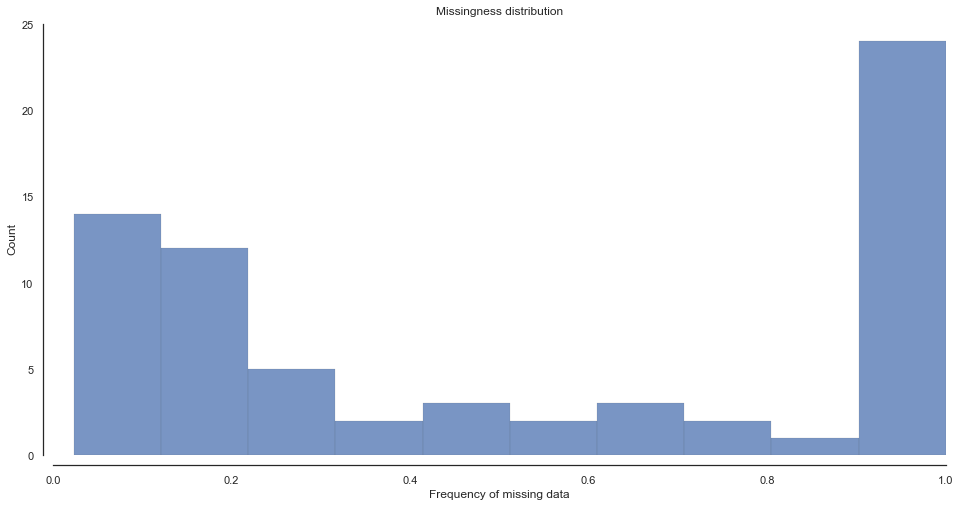

In [537]:
import seaborn as sns
import matplotlib.pyplot as plt
import colorcet as cc

palette = sns.color_palette(cc.glasbey, n_colors=arr.shape[3])

sns.set(style="white")
fig, ax = plt.subplots(figsize=(16, 8))
plt.xlim(0, 1)
sns.histplot(
    ax=ax,
    data=qc_df,
    x="missing_freq",
    bins=10,
    multiple="stack",
    palette=palette,
    edgecolor=".3",
    linewidth=0.1,
    legend=False,
)
plt.title("Missingness distribution")
plt.xlabel("Frequency of missing data")
sns.set_style("ticks")
sns.despine(offset=10, trim=True)

### Speed histograms

In [538]:
%%capture
import utils.trx_utils as trx_utils
import importlib

importlib.reload(trx_utils)
node_vels = trx_utils.instance_node_velocities(arr, 0, arr.shape[0])

KeyboardInterrupt: 

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/Users/danielruttenberg/opt/miniconda2/envs/sleap/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


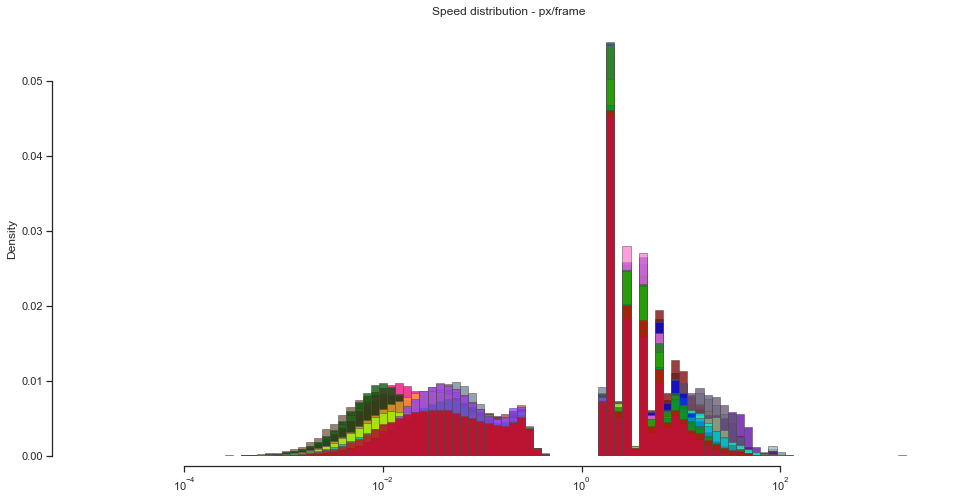

In [ ]:
node_names = {"abdomen": 0, "tag": 1, "head": 2, "thorax": 3}

vels = node_vels[:, node_names["tag"], :]
print(vels)
fig, ax = plt.subplots(figsize=(16, 8))
vels[np.where(vels== 0)] = np.nan
sns.histplot(
    ax=ax,
    data=vels,
    bins=100,
    multiple="stack",
    palette=palette,
    edgecolor=".3",
    linewidth=0.5,
    log_scale=True,
    legend=False,
    stat="density"
)
plt.title("Speed distribution - px/frame")
sns.set_style("ticks")
sns.despine(offset=10, trim=True)

(68, 9500, 2)


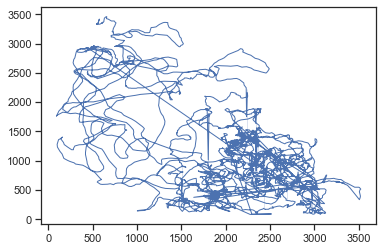

In [539]:
data = arr[500:10000, 1, :, missing_freq<1.0]
print(data.shape)
fig, ax = plt.subplots()
sns.lineplot(x=data[1,:,0], y=data[1,:,1], sort=False, lw=1, color='b')
#sns.lineplot(x=data[2,:,0], y=data[2,:,1], sort=False, lw=1, color='r')
#sns.lineplot(x=data[3,:,0], y=data[3,:,1], sort=False, lw=1, color='y')
#sns.lineplot(x=data[4,:,0], y=data[4,:,1], sort=False, lw=1, color='g')
#labels = ax.get_xticklabels() 
#ax.set_xticklabels(labels, rotation=-30)
plt.show()





In [540]:
print(smooth_median(data[1,:,1]))

[1028.67321777 1032.39880371 1032.47058105 ...           nan           nan
           nan]


Unsmoothed

/Users/danielruttenberg/opt/miniconda2/envs/sleap/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


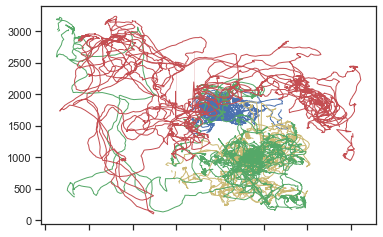

In [548]:
import numpy as np
data = arr[500:10000, 1, :, missing_freq<0.4]
fig, ax = plt.subplots()

for s in np.ma.clump_unmasked(np.ma.masked_invalid(data[5,:,0])):
    xdata = data[5,:,0][s]
    ydata = data[5,:,1][s]
    sns.lineplot(x=xdata, y=ydata, sort=False, lw=1, color='b')
for s in np.ma.clump_unmasked(np.ma.masked_invalid(data[6,:,0])):
    xdata = data[6,:,0][s]
    ydata = data[6,:,1][s]
    sns.lineplot(x=xdata, y=ydata, sort=False, lw=1, color='y')
for s in np.ma.clump_unmasked(np.ma.masked_invalid(data[7,:,0])):
    xdata = data[7,:,0][s]
    ydata = data[7,:,1][s]
    sns.lineplot(x=xdata, y=ydata, sort=False, lw=1, color='g')
for s in np.ma.clump_unmasked(np.ma.masked_invalid(data[8,:,0])):
    xdata = data[8,:,0][s]
    ydata = data[8,:,1][s]
    sns.lineplot(x=xdata, y=ydata, sort=False, lw=1, color='r')
labels = ax.get_xticklabels() 
ax.set_xticklabels(labels, rotation=-30)
plt.show()


/Users/danielruttenberg/opt/miniconda2/envs/sleap/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


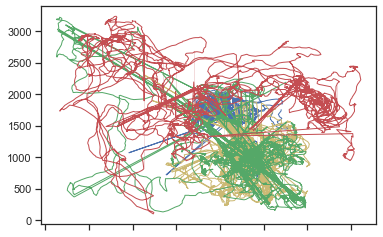

In [549]:
import numpy as np
data = arr[500:10000, 1, :, missing_freq<0.4]
data = trx_utils.fill_missing(data, kind = "linear", limit=50)
fig, ax = plt.subplots()

for s in np.ma.clump_unmasked(np.ma.masked_invalid(data[5,:,0])):
    xdata = data[5,:,0][s]
    ydata = data[5,:,1][s]
    sns.lineplot(x=xdata, y=ydata, sort=False, lw=1, color='b')
for s in np.ma.clump_unmasked(np.ma.masked_invalid(data[6,:,0])):
    xdata = data[6,:,0][s]
    ydata = data[6,:,1][s]
    sns.lineplot(x=xdata, y=ydata, sort=False, lw=1, color='y')
for s in np.ma.clump_unmasked(np.ma.masked_invalid(data[7,:,0])):
    xdata = data[7,:,0][s]
    ydata = data[7,:,1][s]
    sns.lineplot(x=xdata, y=ydata, sort=False, lw=1, color='g')
for s in np.ma.clump_unmasked(np.ma.masked_invalid(data[8,:,0])):
    xdata = data[8,:,0][s]
    ydata = data[8,:,1][s]
    sns.lineplot(x=xdata, y=ydata, sort=False, lw=1, color='r')
labels = ax.get_xticklabels() 
ax.set_xticklabels(labels, rotation=-30)
plt.show()


KeyboardInterrupt: 

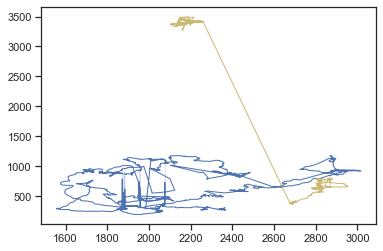

In [ ]:
data = arr[500:10000, 1, :, missing_freq<0.3]
fig, ax = plt.subplots()
smoothx = smooth_median(data[1,:,0])
smoothy = smooth_median(data[1,:,1])
for s in np.ma.clump_unmasked(np.ma.masked_invalid(smoothx)):
    xdata = smoothx[s]
    ydata = smoothy[s]
    sns.lineplot(x=xdata, y=ydata, sort=False, lw=1, color='b')
smoothx = smooth_median(data[4,:,0])
smoothy = smooth_median(data[4,:,1])
for s in np.ma.clump_unmasked(np.ma.masked_invalid(smoothx)):
    xdata = smoothx[s]
    ydata = smoothy[s]
    sns.lineplot(x=xdata, y=ydata, sort=False, lw=1, color='y')
smoothx = smooth_median(data[5,:,0])
smoothy = smooth_median(data[5,:,1])
for s in np.ma.clump_unmasked(np.ma.masked_invalid(smoothx)):
    xdata = smoothx[s]
    ydata = smoothy[s]
    sns.lineplot(x=xdata, y=ydata, sort=False, lw=1, color='g')
smoothx = smooth_median(data[8,:,0])
smoothy = smooth_median(data[8,:,1])
for s in np.ma.clump_unmasked(np.ma.masked_invalid(smoothx)):
    xdata = smoothx[s]
    ydata = smoothy[s]
    sns.lineplot(x=xdata, y=ydata, sort=False, lw=1, color='r')
labels = ax.get_xticklabels() 
ax.set_xticklabels(labels, rotation=-30)
plt.show()


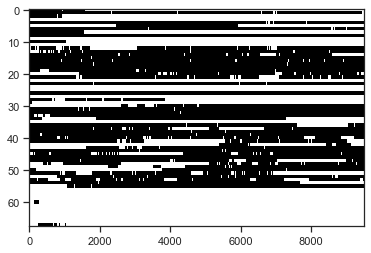

In [550]:
data = arr[500:10000, 1, :]
data = np.isnan(data)
data = data[:,0,:]
data=data.T

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(data, aspect='auto', cmap=plt.cm.gray, interpolation='nearest')

(68, 9500, 2)
[[[2324.26269531 2380.41381836 3508.67456055 ...           nan
             nan           nan]
  [ 104.61708832 1028.67321777  692.41680908 ...           nan
             nan           nan]]

 [[2320.36425781 2376.2890625  3500.13037109 ...           nan
             nan           nan]
  [ 104.64466858 1032.47058105  688.76928711 ...           nan
             nan           nan]]

 [[2324.45922852 2380.20361328 3484.60986328 ...           nan
             nan           nan]
  [ 104.49255371 1032.69824219  692.2331543  ...           nan
             nan           nan]]

 ...

 [[          nan           nan           nan ...           nan
             nan           nan]
  [          nan           nan           nan ...           nan
             nan           nan]]

 [[          nan           nan           nan ...           nan
             nan           nan]
  [          nan           nan           nan ...           nan
             nan           nan]]

 [[          nan    

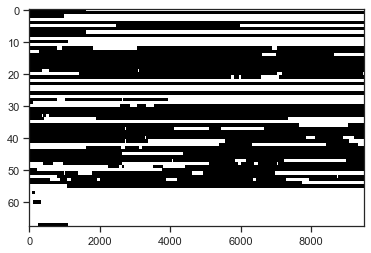

In [551]:
import utils.trx_utils as trx_utils


data = arr[500:10000, 1, :, missing_freq<1]
print(data.shape)
data = data.transpose(1,2,0)
print(data)
print(data.shape)
data = trx_utils.fill_missing(data, kind = "linear", limit=50)
data = np.isnan(data)
data = data[:,0,:]
data=data.T

print(data)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(data, aspect='auto', cmap=plt.cm.gray, interpolation='nearest')